Trusted
Jupyter Server: local
Python 3: Idle





row_num: a number uniquely identifying each row.

• locale: the platform of the session.

• day_of_week: Mon-Fri, the day of the week of the session.

• hour_of_day: 00-23, the hour of the day of the session.

• agent_id: the device used for the session.

• entry_page: describes the landing page of the session.

• path_id_set: shows all the locations that were visited during the session.

• traffic_type: indicates the channel the user cane through eg. search engine, email, ...

• session_duration: the duration in seconds of the session.

• hits: the number of interactions with the trivago page during the session.

Task: Note that the column “hits” has missing values. Use this data to build a model that predicts the number of hits per session, depending on the given parameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy.random as nr
import scipy.stats as ss
import math
import functions as fn

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Data cleaning and basic statistics

In [2]:
df_original = pd.read_csv('MLDataScientistCaseStudyData2020.csv', header = None )
df_original.columns = ["row_num","locale","day_of_week","hour_of_day","agent_id","entry_page","path_id","traffic_type","session_duration","hits"]
df_original.head()

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id,traffic_type,session_duration,hits
0,1,L1,Saturday,23,1,2100,34308;0;183,1,617,\N
1,2,L3,Sunday,8,9,2113,32131;0,2,0,\N
2,3,L3,Saturday,14,9,2100,34330;0,6,17,\N
3,4,L2,Saturday,14,8,2116,89172;0,3,3,11
4,5,L5,Friday,9,2,2100,31777;0,1,610,67


Checking if there are wrong cells

In [3]:
(df_original.astype(np.object) == '?').any()

row_num             False
locale              False
day_of_week         False
hour_of_day         False
agent_id            False
entry_page          False
path_id             False
traffic_type        False
session_duration    False
hits                False
dtype: bool

In [4]:
(df_original.astype(np.object) == '\\N').any()

row_num             False
locale              False
day_of_week         False
hour_of_day         False
agent_id            False
entry_page          False
path_id             False
traffic_type        False
session_duration     True
hits                 True
dtype: bool

There are some rows without "Session_duration" and "hits". For the former I will check how many rows have missing values. The latter are the ones that I need to predict.

In [5]:
indexes = df_original['session_duration'] == '\\N'
df_original.dtypes

row_num              int64
locale              object
day_of_week         object
hour_of_day          int64
agent_id             int64
entry_page           int64
path_id             object
traffic_type         int64
session_duration    object
hits                object
dtype: object

Imputing the mean to the four missing values in the 'session_duration'

In [6]:
df_original['session_duration'] = df_original['session_duration'].replace('\\N', np.nan)
df_original['session_duration'] = df_original['session_duration'].astype(float)
mean = df_original['session_duration'].mean(skipna=True)
df_original['session_duration'].fillna(value=mean, inplace = True)
df_original['session_duration'] = df_original['session_duration'].astype(int)

In [7]:
df_original[indexes]

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id,traffic_type,session_duration,hits
96866,96867,L3,Friday,2,8,8101,35021;0,1,600,2
201828,201829,L3,Wednesday,0,1,8101,0;87192,1,600,\N
356451,356452,L1,Sunday,22,8,8101,0;102548,1,600,2
699208,699209,L3,Monday,0,1,8101,0;35094,1,600,\N


I will split the data into two pd.DataFrames: df_goal contains the rows where the hits are missing. df_test contains the remaining rows that I will use to perform a linear regression and train a NN.

In [8]:
df_goal = df_original.loc[df_original['hits'] == '\\N'] 
df_test = df_original.loc[df_original['hits']!= '\\N']

# Now I can cast the hits into int
df_test['hits'] = df_test['hits'].astype(int)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
print(df_goal.shape)
print(df_test.shape)

(345247, 10)
(603947, 10)


# Working on a fraction of the data

In [10]:
frac = 0.5
df_reduced = df_test.sample(frac = frac)
df_test.dtypes

row_num              int64
locale              object
day_of_week         object
hour_of_day          int64
agent_id             int64
entry_page           int64
path_id             object
traffic_type         int64
session_duration     int64
hits                 int64
dtype: object

In the "path_id" there are some empty cells that account roughly for 2% of the data

In [11]:
n_missing = df_test['path_id'].isnull().sum()
print(n_missing/len(df_test.index))

n_missing_goal = df_goal['path_id'].isnull().sum()
print(n_missing_goal/len(df_goal.index))


0.022427464661634217
0.019884314708020635


In order to test first the methods that I will use, I will avoud the rows with empty 'path_id. Therefore, I split the data again. This time in a df_complet that does not have empty rows in 'path_id'. df_incomplete accounts for the remaining rows

In [12]:
df_complete = df_reduced[df_reduced['path_id'].notna()]
df_incomplete = df_reduced[df_reduced['path_id'].isna()]

Now I will explore the data looking for class inbalance and  

In [13]:
fn.frequency_table(df_complete, df_complete.columns)


For column row_num
2047      1
679455    1
379116    1
345100    1
383214    1
         ..
566206    1
742336    1
220097    1
738242    1
530435    1
Name: row_num, Length: 295121, dtype: int64
There are 295121 unique values

For column locale
L3    117185
L6     49258
L2     44355
L5     40137
L4     31376
L1     12810
Name: locale, dtype: int64
There are 6 unique values

For column day_of_week
Monday       47235
Tuesday      45069
Wednesday    43663
Thursday     42421
Sunday       42390
Friday       38716
Saturday     35627
Name: day_of_week, dtype: int64
There are 7 unique values

For column hour_of_day
19    18577
20    18473
18    18122
17    17887
16    17211
15    16895
21    16086
14    15727
13    14417
22    13409
12    12998
0     12025
23    11497
11    11473
1     10557
10    10131
2      9307
9      8999
8      8138
3      7653
7      7181
6      6438
4      6119
5      5801
Name: hour_of_day, dtype: int64
There are 24 unique values

For column agent_id
10    85433
1   

## Assumption

Instead of working with the path_id set I will count the number of paths and work with that instead. Special care is required with path_id as the values have strings and floats. Moreover, there are some rows without any value. I created the function path_counter to extract the number of path_ids

In [14]:
df_complete['n_ids'] = df_complete['path_id'].apply(lambda x:fn.path_counter(x))
df_complete.dtypes

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


row_num              int64
locale              object
day_of_week         object
hour_of_day          int64
agent_id             int64
entry_page           int64
path_id             object
traffic_type         int64
session_duration     int64
hits                 int64
n_ids                int64
dtype: object

In [15]:
fn.frequency_table(df_complete, ["n_ids"])


For column n_ids
2     207954
1      46824
3      29236
4       6859
5       2272
6        972
7        418
8        238
9        112
10        73
11        57
12        33
13        22
16        12
14        11
15         9
18         4
20         4
17         3
22         2
23         2
39         1
25         1
31         1
42         1
Name: n_ids, dtype: int64
There are 25 unique values


In [16]:
df_complete['n_ids'].describe()

count    295121.00000
mean          2.04613
std           0.80889
min           1.00000
25%           2.00000
50%           2.00000
75%           2.00000
max          42.00000
Name: n_ids, dtype: float64

# Data exploration

First I will create a correlation matrix

<AxesSubplot:>

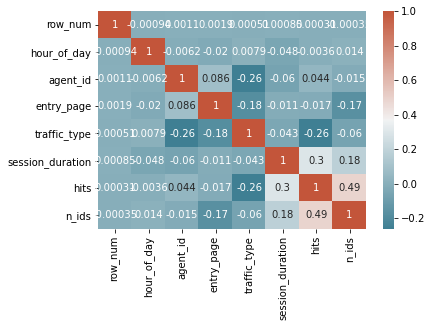

In [17]:
corr = df_complete.corr()
# plot the heatmap 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

There is a strong correlation between n_ids and the hits. It makes sense as the more paths one access, the more hits. Additionally, the session duration has a correlation as expected. Below, I will explore all the variables in more detail. 

## Categorical variables


## Locale

<AxesSubplot:xlabel='locale', ylabel='count'>

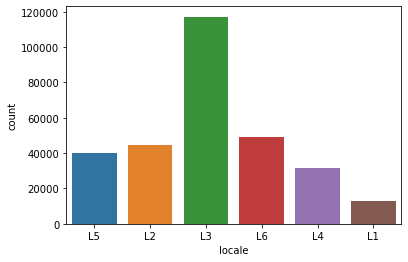

In [18]:
sns.countplot(x="locale", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


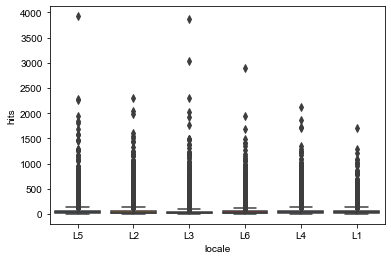

In [19]:
fig, ax = fn.plot_box(df_complete, 'locale')  

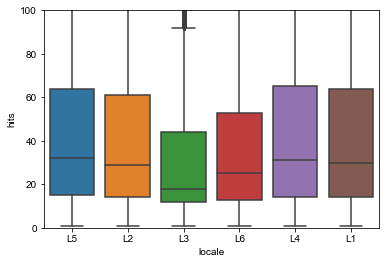

In [20]:
ax.set_ylim(0,100)
fig

The medians and the inner 2 quartiles of all the locales overlap so probably this variable is not going to be very good to predict the 'hits'

# Traffic type

<AxesSubplot:xlabel='traffic_type', ylabel='count'>

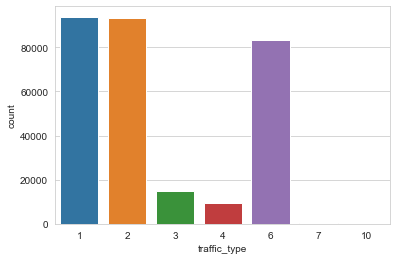

In [21]:
sns.countplot(x="traffic_type", data=df_complete)


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


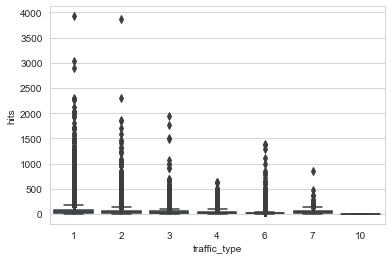

In [22]:
fig, ax = fn.plot_box(df_complete, 'traffic_type')  

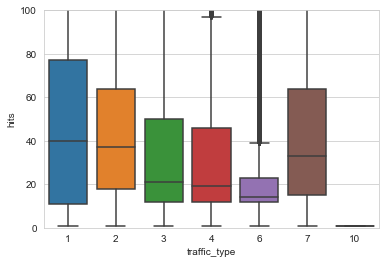

In [23]:
ax.set_ylim(0,100)
fig

## *Assumption*
With the results above (see countplot), it seems that is a good idea to agreggate some of the traffic types. I will use the function group_cat to aggregate categories with less than 10% of the total number of hits. This is a very strong assumption as I do not know the traffic type and I am setting the threshold very high.

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='traffic_type_aggr', ylabel='count'>

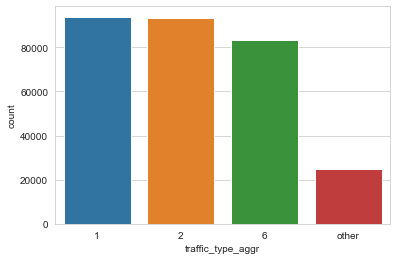

In [24]:
group, frequency = fn.group_cat(df_complete, 'traffic_type', 0.1)
df_complete['traffic_type_aggr'] = df_complete['traffic_type'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="traffic_type_aggr", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


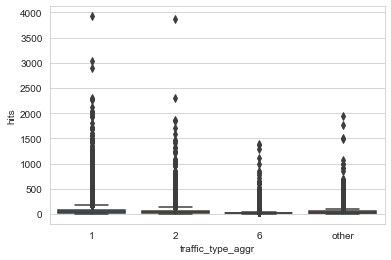

In [25]:
fig, ax = fn.plot_box(df_complete, 'traffic_type_aggr') 

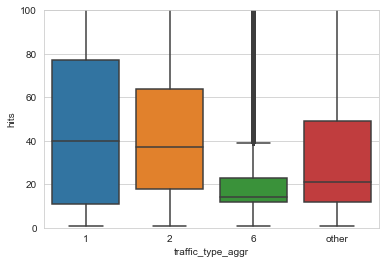

In [26]:
ax.set_ylim(0,100)
fig

## Agent Id

<AxesSubplot:xlabel='agent_id', ylabel='count'>

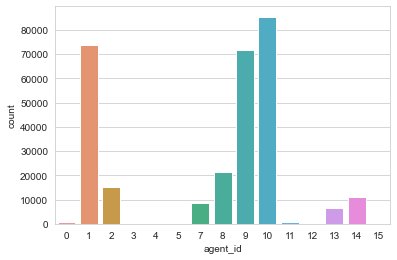

In [27]:
sns.countplot(x="agent_id", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


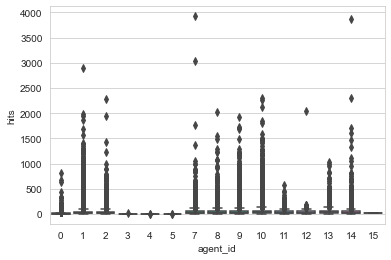

In [28]:
fig, ax = fn.plot_box(df_complete, 'agent_id')  

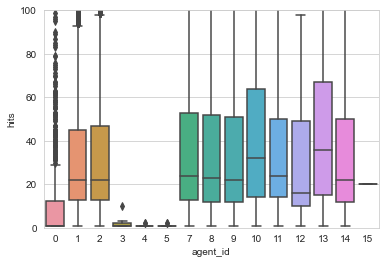

In [29]:
ax.set_ylim(0,100)
fig

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='agent_aggr', ylabel='count'>

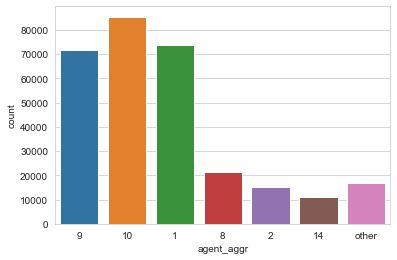

In [30]:
group, frequency = fn.group_cat(df_complete, 'agent_id', 0.03)
df_complete['agent_aggr'] = df_complete['agent_id'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="agent_aggr", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


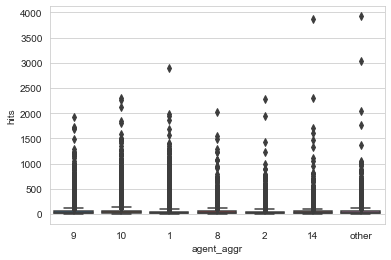

In [31]:
fig, ax = fn.plot_box(df_complete, 'agent_aggr')  

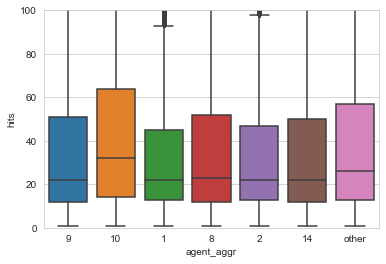

In [32]:
ax.set_ylim(0,100)
fig

## Entry Page

<AxesSubplot:xlabel='entry_page', ylabel='count'>

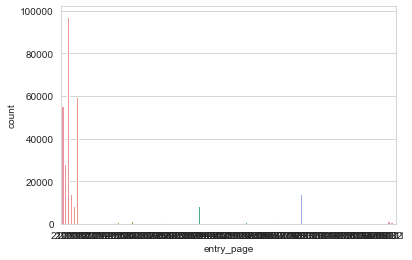

In [33]:
sns.countplot(x="entry_page", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='entry_aggr', ylabel='count'>

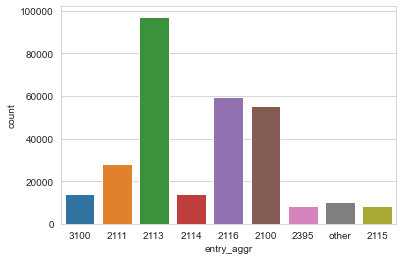

In [34]:
group, frequency = fn.group_cat(df_complete, 'entry_page', 0.01)
df_complete['entry_aggr'] = df_complete['entry_page'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="entry_aggr", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


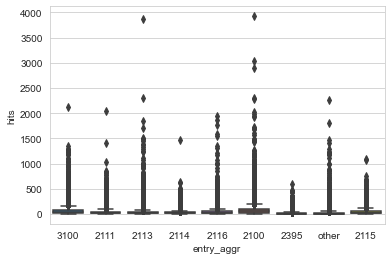

In [35]:
fig, ax = fn.plot_box(df_complete, 'entry_aggr')  

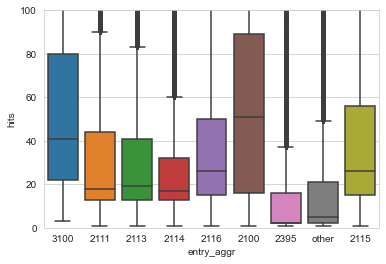

In [36]:
ax.set_ylim(0,100)
fig

This variable might have an influence as the medians are far from each other and some of them are right-skewed

## n_ids
## *Assumption*
I will assume n_ids as categorical instead of numeric. Later, with the NN I will comment more on this.

<AxesSubplot:xlabel='n_ids', ylabel='count'>

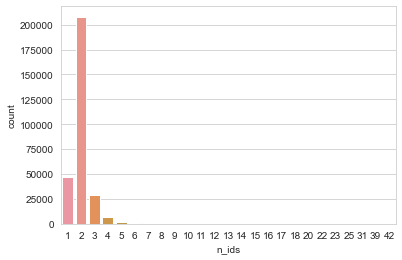

In [37]:
sns.countplot(x="n_ids", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='n_ids_aggr', ylabel='count'>

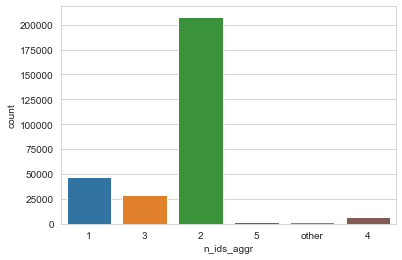

In [38]:
group, frequency = fn.group_cat(df_complete, 'n_ids', 0.005)
df_complete['n_ids_aggr'] = df_complete['n_ids'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="n_ids_aggr", data=df_complete)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


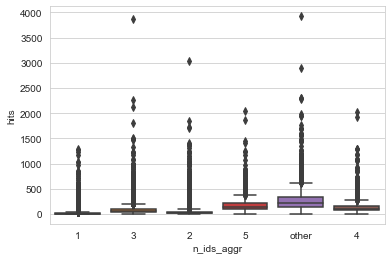

In [39]:
fig, ax = fn.plot_box(df_complete, 'n_ids_aggr')  

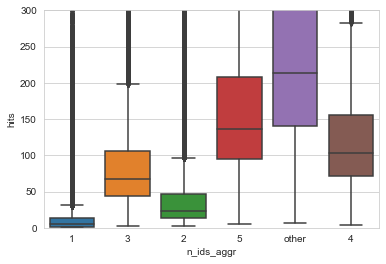

In [40]:
ax.set_ylim(0,300)
fig

# Transforming numeric variables


## Session duration


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


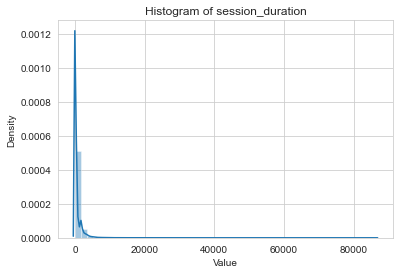

In [41]:
fn.hist_plot(df_complete, ['session_duration'])

In [42]:
df_complete['session_duration'].value_counts()

0        23645
13        5007
3         4682
14        4619
15        4130
         ...  
5480         1
7273         1
25702        1
15213        1
17783        1
Name: session_duration, Length: 8484, dtype: int64

I will need to transformate this variable in order to make it look more like a normal distribution. I can apply a logarithmic transformation. As there are some values with 0 seconds, actually most of them, I will apply log(x+1)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


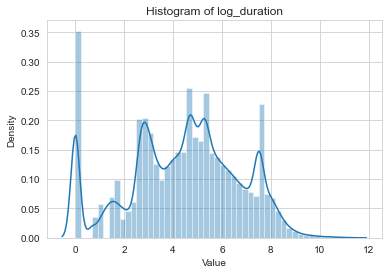

In [43]:
df_complete[['log_duration']] = df_complete[['session_duration']].applymap(np.log1p)
fn.hist_plot(df_complete, ['log_duration'])

## Hour of the day

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


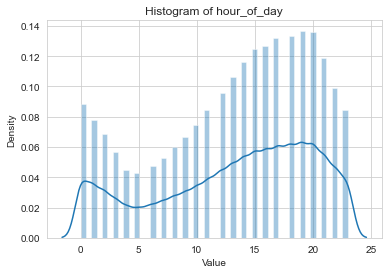

In [44]:
fn.hist_plot(df_complete, ['hour_of_day'])

Turning into a cyclical variable

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future versio

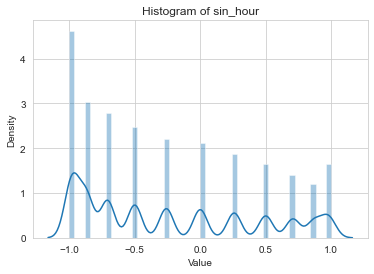

In [45]:
df_complete['sin_hour'] = np.sin(2*np.pi*df_complete['hour_of_day']/24)
df_complete['cos_hour'] = np.cos(2*np.pi*df_complete['hour_of_day']/24)
fn.hist_plot(df_complete, ['sin_hour'])

## Day of the week
I will convert the days into integers with the following dictionary. Later, I will make them cyclical variables as well. 

In [46]:
dict_day =  {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5,'Sunday':6}
df_complete['day_of_week_num'] = [dict_day[x] for x in df_complete['day_of_week']]

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='day_of_week_num', ylabel='cos_day'>

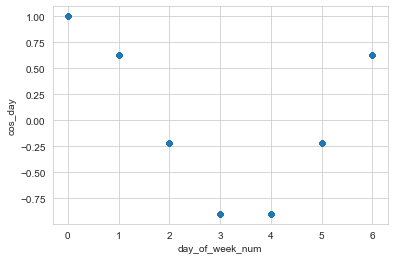

In [47]:
df_complete['sin_day'] = np.sin(2*np.pi*df_complete['day_of_week_num']/7)
df_complete['cos_day'] = np.cos(2*np.pi*df_complete['day_of_week_num']/7)
df_complete.plot(x = 'day_of_week_num', y = 'cos_day', kind='scatter')

## Hits(Label)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


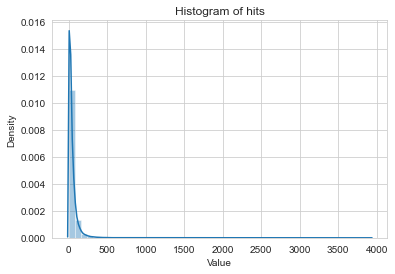

In [48]:
fn.hist_plot(df_complete, ['hits'])


The 'hits' distribution is also right-skewed. Therefore, I will apply a logarithmic transformation

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


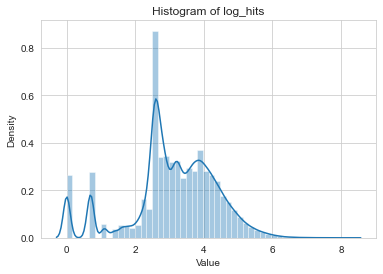

In [49]:
df_complete[['log_hits']] = df_complete[['hits']].applymap(math.log)
fn.hist_plot(df_complete, ['log_hits'])

# Preparing the model matrix

## Creating dummy variables from categorical features

In [50]:
categorical_columns = ['agent_aggr','locale', 'entry_aggr', 'traffic_type_aggr','n_ids_aggr']

for i,col in enumerate(categorical_columns):
    print(col)
    print("These are the dummy variables %s"%(df_complete[col].unique()))
    temp = fn.encode_string(df_complete[col])
    if i == 0:
        features = temp
    else:
        features = np.concatenate([features, temp], axis = 1)
rows ,n_categorical = features.shape
print("\nAfter encoding there are %s categorical variables"%n_categorical)

agent_aggr
These are the dummy variables ['9' '10' '1' '8' '2' '14' 'other']
locale
These are the dummy variables ['L5' 'L2' 'L3' 'L6' 'L4' 'L1']
entry_aggr
These are the dummy variables ['3100' '2111' '2113' '2114' '2116' '2100' '2395' 'other' '2115']
traffic_type_aggr
These are the dummy variables ['1' '2' '6' 'other']
n_ids_aggr
These are the dummy variables ['1' '3' '2' '5' 'other' '4']

After encoding there are 32 categorical variables


# Adding the numerical features

In [51]:
df_complete.columns

Index(['row_num', 'locale', 'day_of_week', 'hour_of_day', 'agent_id',
       'entry_page', 'path_id', 'traffic_type', 'session_duration', 'hits',
       'n_ids', 'traffic_type_aggr', 'agent_aggr', 'entry_aggr', 'n_ids_aggr',
       'log_duration', 'sin_hour', 'cos_hour', 'day_of_week_num', 'sin_day',
       'cos_day', 'log_hits'],
      dtype='object')

In [52]:
features = np.concatenate([features, np.array(df_complete[['log_duration', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day']])], axis = 1)
np.shape(features)

(295121, 37)

## Splitting the dataset

I will create random sample cases for independent training and test datasets.

In [53]:
nr.seed(9988)
labels = np.array(df_complete['log_hits'])
indx = range(features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train = features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

## Rescale numeric features
To prevent features from having an influence on the model training because then have a larger range of numeric variables. I will rescale the numeric features. Also, rescaling will help to asses the importance of the variables from the coefficients

In [54]:
scaler = preprocessing.StandardScaler().fit(x_train[:,n_categorical:])
x_train[:,n_categorical:] = scaler.transform(x_train[:,n_categorical:])
x_test[:,n_categorical:] = scaler.transform(x_test[:,n_categorical:])
print(x_train.shape)
x_train[:1,:]

(236096, 37)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.17004145,  1.85623339,  0.04457877,
         1.06381114,  0.82118652]])

# Building the linear regression model

In [55]:
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [56]:
print(lin_mod.intercept_)
print(lin_mod.coef_)
print(np.shape(lin_mod.coef_))

0.0
[-4.26731803e+11 -4.26731803e+11 -4.26731803e+11 -4.26731803e+11
 -4.26731803e+11 -4.26731803e+11 -4.26731803e+11  1.15554145e+12
  1.15554145e+12  1.15554145e+12  1.15554145e+12  1.15554145e+12
  1.15554145e+12  8.77963802e+11  8.77963802e+11  8.77963802e+11
  8.77963802e+11  8.77963802e+11  8.77963802e+11  8.77963802e+11
  8.77963802e+11  8.77963802e+11 -3.42490181e+12 -3.42490181e+12
 -3.42490181e+12 -3.42490181e+12  1.81812836e+12  1.81812836e+12
  1.81812836e+12  1.81812836e+12  1.81812836e+12  1.81812836e+12
  6.68996777e-01 -1.11770630e-03  8.78906250e-03  5.95092773e-04
 -5.03921509e-03]
(37,)


## Evaluating the model

In [57]:
y_score = lin_mod.predict(x_test) 
fn.print_metrics(y_test, y_score) 

Mean Square Error      = 0.3341122898058772
Root Mean Square Error = 0.5780244716323671
Mean Absolute Error    = 0.43701277013234724
Median Absolute Error  = 0.3335552884109593
R^2                    = 0.7842941066816771


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


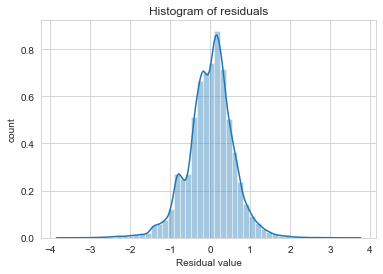

In [58]:
fn.hist_resids(y_test, y_score) 

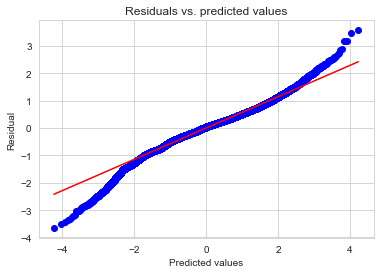

In [59]:
fn.resid_qq(y_test, y_score)   


As with the histogram, the Q-Q Normal plot indicates the residuals are close to normally distributed for small residuals.

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


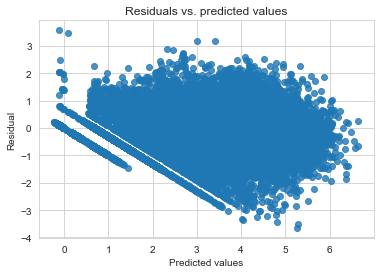

In [60]:
fn.resid_plot(y_test, y_score) 

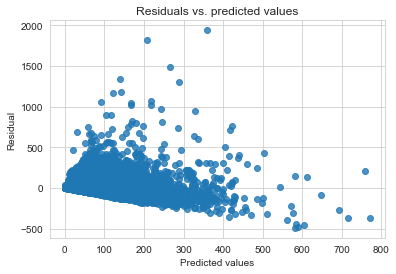

In [61]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
fn.resid_plot(y_test_untransform, y_score_untransform) 

The plot shows that there is some structure in the residuals of the predicted hits. The model is not good to predict large values and evend in mid-ranges have very innacurate predictions.

# Neural Network
I will build a NN for the same dataset to compare the results. I expect that the results improve and that it can predict some of the substructures and rare events that the linear regression is not able to capture.

In [62]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

As a first approximation, I will use one hidden layer of size 100. With the amount of data ~0.6 M. A better topology can be used and optimised later. For now, just comparing with the linear regression

In [63]:
regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes = (100))

In [64]:
regr.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=100, max_iter=500, random_state=1)

In [65]:
y_score = regr.predict(x_test)

In [66]:
fn.print_metrics(y_test, y_score) 

Mean Square Error      = 0.22599413990390207
Root Mean Square Error = 0.47538840951784056
Mean Absolute Error    = 0.32388040973287685
Median Absolute Error  = 0.20799367959915527
R^2                    = 0.8540961547358809


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


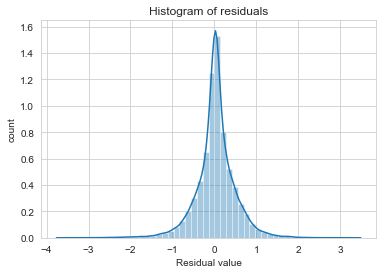

In [67]:
fn.hist_resids(y_test, y_score) 

The RMSE is lower than with the linear regression and the histogram of residuals is more symmetrical, improving a bit the results.

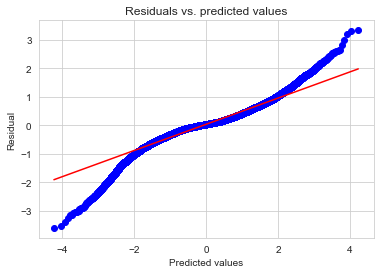

In [68]:
fn.resid_qq(y_test, y_score)   

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


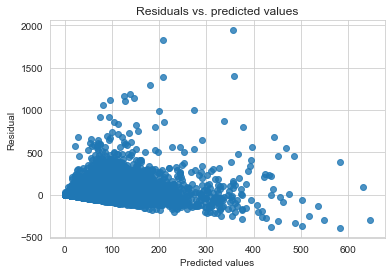

In [69]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
fn.resid_plot(y_test_untransform, y_score_untransform) 

There are still some points that are not captured well.

## Cross validation

In [70]:
scoring = ['neg_root_mean_squared_error']
scores = ms.cross_validate(regr, x_train, y_train, scoring=scoring,cv=10, return_train_score=False)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [71]:
fn.print_cv(scores)  

test_neg_root_mean_squared_error
Fold  1    -0.481 
Fold  2    -0.483 
Fold  3    -0.481 
Fold  4    -0.474 
Fold  5    -0.479 
Fold  6    -0.487 
Fold  7    -0.475 
Fold  8    -0.476 
Fold  9    -0.478 
Fold 10    -0.482 
----------------------------------------
Mean       -0.480
Std        0.004


## Bagging

If the results from the cross validation had a larger variance, bagging would be a good way to improve the model by using the results from several NN.

In [73]:
from sklearn.ensemble import BaggingRegressor

In [74]:
regr_bagging = BaggingRegressor(base_estimator=regr, n_estimators=5, random_state=0)

In [75]:
regr_bagging.fit(x_train, y_train)

BaggingRegressor(base_estimator=MLPRegressor(hidden_layer_sizes=100,
                                             max_iter=500, random_state=1),
                 n_estimators=5, random_state=0)

In [77]:
y_score = regr_bagging.predict(x_test)
fn.print_metrics(y_test, y_score) 

Mean Square Error      = 0.22369561946640468
Root Mean Square Error = 0.4729647127074119
Mean Absolute Error    = 0.32036843050596486
Median Absolute Error  = 0.2061763805169572
R^2                    = 0.8555801001620394


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


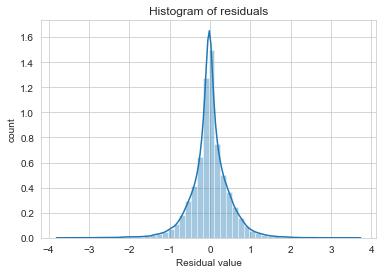

In [78]:
fn.hist_resids(y_test, y_score) 

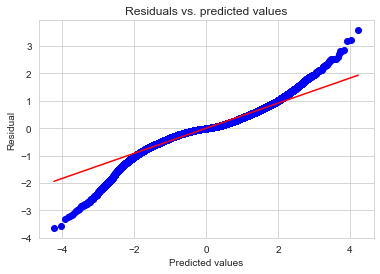

In [80]:
fn.resid_qq(y_test, y_score)  